In [30]:

##utiliti
import time
import copy
import itertools
##data,visul
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
##deep learning
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timm.data import resolve_model_data_config, create_transform
from torchinfo import summary
import timm
print("done")

done


# A.FUNCTION DEFINE

## A.1 DATA PREPARE

In [31]:
# -------------------------
# 1. Chuẩn bị transform
# -------------------------
def get_transforms_timm(model_name, is_training=True):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)
    model = model.eval()  # Chế độ inference
    data_config = resolve_model_data_config(model)  # Lấy config phù hợp với model
    transform = create_transform(**data_config, is_training=is_training)
    return transform


print ("done")


done


In [32]:
# -------------------------
# 2. Load dataset và chia tập
# -------------------------
def load_dataset(dataset_path, train_transform, val_transform, split_ratio=[0.8, 0.1, 0.1]):
    # Tạo dataset đầy đủ với transform của train (mặc định)
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
    dataset_size = len(full_dataset)
    
    
    if len(split_ratio) == 2:
        train_ratio, val_ratio = split_ratio
        test_ratio = 1.0 - (train_ratio + val_ratio)
        ratios = [train_ratio, val_ratio, test_ratio]
    elif len(split_ratio) == 3:
        ratios = split_ratio
    else:
        ratios = [0.8, 0.1, 0.1]
    
    # Tính số lượng mẫu cho từng tập theo tỷ lệ
    sizes = [int(r * dataset_size) for r in ratios]
    # Điều chỉnh kích thước của tập cuối (test) để đảm bảo tổng bằng dataset_size
    sizes[-1] = dataset_size - sum(sizes[:-1])
    
    # Phân chia dataset thành 3 phần: train, validation và test
    train_set, val_set, test_set = random_split(full_dataset, sizes)
    
    # Gán transform mới cho tập validation và test
    val_set.dataset.transform = val_transform
    test_set.dataset.transform = val_transform
    
    return train_set, val_set, test_set, len(full_dataset.classes)
def get_dataloaders(train_set, val_set, test_set, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader
print("done")


done


## A.2 MODEL PREPARE

In [33]:
class MyModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MyModel, self).__init__()
        self.base_model = base_model

        # Lấy số feature cuối cùng
        self.embed_dim = base_model.num_features

        # Tạo classifier
        self.classifier = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        features = self.base_model.forward_features(x)  # Hoạt động cho cả ViT & ResNet
        
        # Nếu là ViT, feature shape (B, num_tokens, embed_dim) → Lấy mean trên token
        if features.dim() == 3: 
            pooled = features.mean(dim=1)
        else:  # CNN có shape (B, C, H, W) → Dùng global average pooling
            pooled = features.mean(dim=[2, 3])     
        logits = self.classifier(pooled)
        return logits
def get_model(num_classes, basemodel, device, freeze=False):
    base_model = timm.create_model(basemodel, pretrained=True, num_classes=0) 
    if freeze==True:
        for param in base_model.parameters():
            param.requires_grad = False
    
    model = MyModel(base_model, num_classes).to(device)
    return model

print("done")


done


## A.3 TRAINING PROCEDURE

In [34]:
def train_model(model, train_loader, val_loader, device, num_epochs=10, 
                threshold=0.9, lr_patience=2, stop_patience=4, factor=0.5):
    """
    Huấn luyện model với các kỹ thuật:
      - LR Scheduling: Điều chỉnh learning rate khi không cải thiện theo chỉ số được theo dõi
      - Early Stopping: Dừng training nếu đã điều chỉnh LR quá số lần cho phép
      - Checkpoint: Lưu lại trạng thái model tốt nhất dựa trên validation loss
      
    Tham số:
      - threshold: ngưỡng để lựa chọn metric theo training accuracy hoặc validation loss
      - lr_patience: số epoch không cải thiện trước khi giảm LR
      - stop_patience: số lần điều chỉnh LR liên tiếp không cải thiện trước khi dừng training
      - factor: hệ số nhân để giảm learning rate (new_lr = old_lr * factor)
    """
    # Khai báo loss và optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
    
    # Các list lưu lại kết quả
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    # Checkpoint: lưu validation loss tốt nhất (và model state)
    best_val_loss_checkpoint = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    best_epoch = 0

    # Các biến dùng cho LR scheduling:
    best_train_acc = 0.0          # theo dõi training accuracy tốt nhất khi train acc < threshold
    best_val_loss_lr = float('inf')  # theo dõi validation loss tốt nhất khi train acc >= threshold
    lr_adjust_counter = 0         # đếm số epoch không cải thiện
    lr_adjust_count = 0           # số lần điều chỉnh LR

    # In header tương tự như log của TensorFlow callback
    header = f'{"Epoch":^6s} {"Loss":^8s} {"Acc":^8s} {"V_loss":^10s} {"V_acc":^8s} {"LR":^10s} {"Next LR":^10s} {"Monitor":^10s} {"%Improv":^10s} {"Duration":^10s}'
    print(header)
    
    total_start = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0
        
        # Huấn luyện theo từng batch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += inputs.size(0)
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = running_corrects / total_train
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Đánh giá trên tập validation
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)
                running_corrects_val += (outputs.argmax(dim=1) == labels).sum().item()
                total_val += inputs.size(0)
                
        epoch_val_loss = running_loss_val / total_val
        epoch_val_acc = running_corrects_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # Lấy learning rate hiện tại trước khi điều chỉnh
        current_lr = optimizer.param_groups[0]['lr']
        next_lr = current_lr  # mặc định sẽ không thay đổi
        monitor = ''
        improvement = 0.0  # % cải thiện so với giá trị tốt nhất trước đó
        
        # Nếu training accuracy dưới threshold thì theo dõi training accuracy,
        # ngược lại thì theo dõi validation loss.
        if epoch_train_acc < threshold:
            monitor = 'accuracy'
            if best_train_acc > 0:
                improvement = (epoch_train_acc - best_train_acc) * 100 / best_train_acc
            else:
                improvement = 0.0
            if epoch_train_acc > best_train_acc:
                best_train_acc = epoch_train_acc
                lr_adjust_counter = 0
                # Cập nhật checkpoint nếu validation loss cũng cải thiện
                if epoch_val_loss < best_val_loss_checkpoint:
                    best_val_loss_checkpoint = epoch_val_loss
                    best_model_state = copy.deepcopy(model.state_dict())
                    best_epoch = epoch + 1
            else:
                lr_adjust_counter += 1
                if lr_adjust_counter >= lr_patience:
                    next_lr = current_lr * factor
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = next_lr
                    print(f"Reducing LR from {current_lr:.6f} to {next_lr:.6f} due to lack of train accuracy improvement.")
                    lr_adjust_counter = 0
                    lr_adjust_count += 1
        else:
            monitor = 'val_loss'
            if best_val_loss_lr < float('inf'):
                improvement = (best_val_loss_lr - epoch_val_loss) * 100 / best_val_loss_lr
            else:
                improvement = 0.0
            if epoch_val_loss < best_val_loss_lr:
                best_val_loss_lr = epoch_val_loss
                lr_adjust_counter = 0
                best_model_state = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
            else:
                lr_adjust_counter += 1
                if lr_adjust_counter >= lr_patience:
                    next_lr = current_lr * factor
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = next_lr
                    print(f"Reducing LR from {current_lr:.6f} to {next_lr:.6f} due to lack of validation loss improvement.")
                    lr_adjust_counter = 0
                    lr_adjust_count += 1
        
        # Early stopping nếu số lần điều chỉnh LR vượt quá giới hạn
        if lr_adjust_count >= stop_patience:
            print(f"Early stopping: LR adjusted {lr_adjust_count} times without improvement.")
            break
        
        epoch_duration = time.time() - epoch_start
        # In log chi tiết cho epoch này
        print(f"{epoch+1:^6d} {epoch_train_loss:^8.3f} {epoch_train_acc*100:^8.3f} {epoch_val_loss:^10.5f} {epoch_val_acc*100:^8.3f} {current_lr:^10.5f} {next_lr:^10.5f} {monitor:^10s} {improvement:^10.2f} {epoch_duration:^10.2f}")
    
    total_duration = time.time() - total_start
    hours = int(total_duration // 3600)
    minutes = int((total_duration % 3600) // 60)
    seconds = total_duration % 60
    print(f"Total training time: {hours}h {minutes}m {seconds:.2f}s")
    
    # Sau khi huấn luyện, load lại trạng thái model tốt nhất
    model.load_state_dict(best_model_state)
    print(f"Best model from epoch {best_epoch} restored.")

    return train_losses, train_accs, val_losses, val_accs

print("done")

done


## A.4 RESULT PROCESSING ( PLOT TRAINING PROCESS , EVALUTION)

### A.4.1 PLOT TRAINING PROCESS

In [35]:
def plot_metrics(train_losses, train_accs, val_losses, val_accs,filename='trainingprocess.png'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses, marker='o', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot([acc*100 for acc in train_accs], marker='o', label='Train Accuracy')
    plt.plot([acc*100 for acc in val_accs], marker='o', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"✅ Training process image saved to {filename}")
    plt.show()
print("done")

done


### A.4.2 CALCULATE FINAL ACC+LOSS

In [36]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total, correct, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += inputs.size(0)
    test_loss = running_loss / total
    test_acc = (correct / total)*100
    #print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")
    return test_loss , test_acc
print("done")

done


### A.4.3 CONFUSION MATRIX ,CLASSIFICATION REPORT

In [37]:
def evaluate_model(model, data_loader, class_names, img_name='confusion-matrix.png',file_name='classificationreport.txt'):
    """
    Hàm này thực hiện dự đoán, tạo confusion matrix và classification report.
    
    Args:
        model: Mô hình đã train.
        data_loader: DataLoader chứa dữ liệu test.
        class_names: Danh sách tên các lớp.
        filename: Tên file để lưu confusion matrix.
    """
    # Bước 1: Predict
    model.eval()  # Chuyển sang chế độ đánh giá
    y_pred, y_true = [], []

    with torch.no_grad():  
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Chuyển về GPU nếu có
            
            outputs = model(inputs)  # Dự đoán logits
            preds = torch.argmax(outputs, dim=1)  # Lấy class có xác suất cao nhất

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Bước 2: Tạo confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment='center', 
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(img_name)
    print(f"✅ Confusion matrix image saved to {img_name}")
    plt.show() 
    # Bước 3: In classification report
    report = sklearn.metrics.classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    with open(file_name, "w") as f:
        f.write("Confusion Matrix:\n")
        f.write(np.array2string(cm) + "\n")
        f.write("\nClassification Report:\n")
        f.write(report) 
    print(f"✅ Classification report saved to {file_name}")
    return y_pred, cm, report


# B. FINE-TUNING

**Dataset**
* Covid (2.5k- 2 classes): '/kaggle/input/sarscov2-ctscan-dataset'
* Lung cancer (15k- 3 classes):  '/kaggle/input/lung-cancer-histopathological-images'
* Brain tumor (7k-4 classes): '/kaggle/input/brain-tumor-mri-dataset'

**Model:**
* DenseNet201 (20M) : 'densenet201.tv_in1k'
* ResNet50 (25M):  'resnet50.a1_in1k'
* ConvNeXt-T (28.5M): 'convnext_tiny.fb_in22k'
* ViT-Small(22M):'vit_small_patch16_224.augreg_in21k'


## B.1 MODEL + DATA + HYPERPARAMETER SELECTION 

In [ ]:
dataset_path= '/kaggle/input/lung-cancer-histopathological-images' #dataset path in kaggle
model_code=   'convnext_tiny.fb_in22k'#model code in timm
dataset_name='Lungcancer' #name of dataset to saving
model_name='ConvNeXt' #name of model to saving
num_epochs=10 #number of epochs to run (data1=30 , data2=10 ,data3=)
lr_patience=2 #patience before edit lr (data1=3 , data2=2)
stop_patience=2 # times edit lr befor stop training (data1=3,data2=2)a
is_freeze=False #model if freeze (not train parameter) or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #device to train CPU /GPU
split_ratio=[0.8, 0.1, 0.1] # ratio of train-test-val 
batch_size=32 # batch size of data (data1=32)

## B.2 DATA PREPARE

In [39]:
train_transform = get_transforms_timm(model_code, is_training=True)
val_transform = get_transforms_timm(model_code, is_training=False)
train_set, val_set, test_set,num_classes = load_dataset(dataset_path, train_transform, val_transform,split_ratio=split_ratio)
train_loader, val_loader, test_loader = get_dataloaders(train_set, val_set, test_set,batch_size=batch_size)
print("done")

done


## B.3 MODEL DEFINE

In [40]:
model = get_model(num_classes, model_code, device, freeze=is_freeze)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
MyModel                                                 [1, 3]                    --
├─ConvNeXt: 1-1                                         --                        1,536
│    └─Sequential: 2-1                                  [1, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                                 [1, 96, 56, 56]           4,704
│    │    └─LayerNorm2d: 3-2                            [1, 96, 56, 56]           192
│    └─Sequential: 2-2                                  [1, 768, 7, 7]            --
│    │    └─ConvNeXtStage: 3-3                          [1, 96, 56, 56]           237,888
│    │    └─ConvNeXtStage: 3-4                          [1, 192, 28, 28]          992,256
│    │    └─ConvNeXtStage: 3-5                          [1, 384, 14, 14]          11,112,960
│    │    └─ConvNeXtStage: 3-6                          [1, 768, 7, 7]            15,470,592
│    └─Identity: 2-3       

##  B.4 TRAINNG

In [41]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader,
device,num_epochs=num_epochs,threshold=0.9,lr_patience=lr_patience,stop_patience=stop_patience)

Epoch    Loss     Acc      V_loss    V_acc       LR      Next LR    Monitor    %Improv    Duration 
  1     0.248    90.775   0.11970    95.600   0.00100    0.00100    val_loss     0.00      273.26  
  2     0.063    97.650   0.03648    98.867   0.00100    0.00100    val_loss    69.52      272.93  
  3     0.039    98.550   0.01186    99.733   0.00100    0.00100    val_loss    67.49      272.65  
  4     0.013    99.500   0.00575    99.733   0.00100    0.00100    val_loss    51.50      272.53  
  5     0.010    99.700   0.11252    96.867   0.00100    0.00100    val_loss   -1856.00    273.08  
  6     0.004    99.908   0.00314    99.800   0.00100    0.00100    val_loss    45.43      272.42  
  7     0.000   100.000   0.00101   100.000   0.00100    0.00100    val_loss    67.93      273.71  
  8     0.000   100.000   0.00050   100.000   0.00100    0.00100    val_loss    50.71      272.88  
  9     0.000   100.000   0.00045   100.000   0.00100    0.00100    val_loss     9.63      273.01  


# C. RESULT 

In [42]:
"SAVE TRAING HISTORY TO CSV"
file_name = f"{dataset_name}-{model_name}-history.csv"
df = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses) + 1)),
    "Train Loss": train_losses,
    "Train Accuracy": [acc * 100 for acc in train_accs],  # Chuyển acc thành %
    "Validation Loss": val_losses,
    "Validation Accuracy": [acc * 100 for acc in val_accs]
})
df.to_csv(file_name, index=False)

print(f"✅ Training results saved to {file_name}")

✅ Training results saved to Lungcancer-ConvNeXt-history.csv


## C.1 TRAINING PLOT

✅ Training process image saved to Lungcancer-ConvNeXt-trainingprocess.png


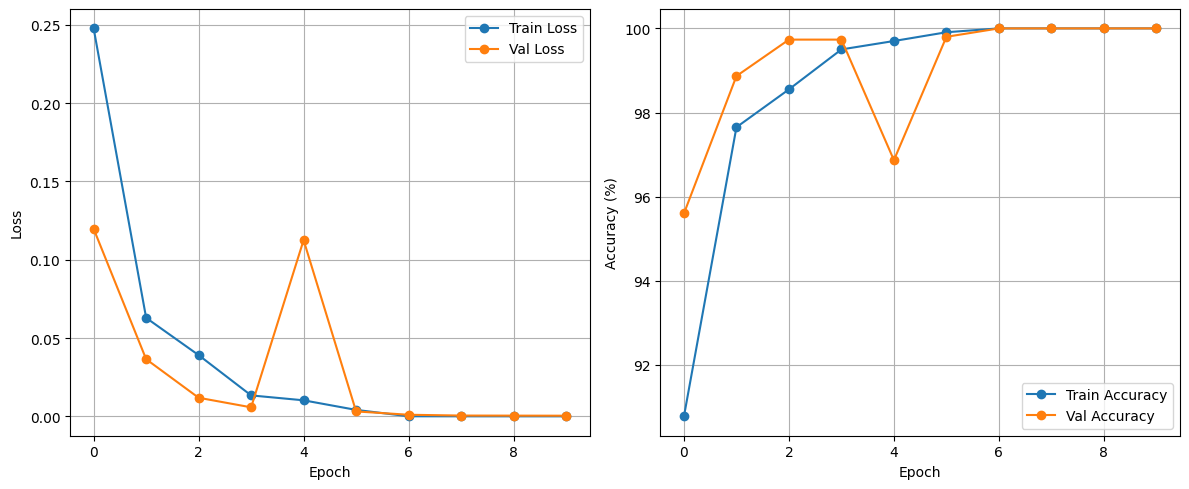

In [43]:
file_name = f"{dataset_name}-{model_name}-trainingprocess.png"
plot_metrics(train_losses, train_accs, val_losses, val_accs,file_name)

## C.2 EVALUATION 

### C.2.1 Train / Test/Val acc+loss

In [44]:
train_loss, train_acc = test_model(model, train_loader)
val_loss, val_acc = test_model(model, val_loader)
test_loss, test_acc = test_model(model, test_loader)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.2f}%")
print('-' * 20)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Tạo tên file lưu kết quả
file_name = f"{dataset_name}-{model_name}-evaluation.txt"
# Ghi kết quả vào file
with open(file_name, "w") as f:
    f.write(f"Train Loss: {train_loss:.4f}\n")
    f.write(f"Train Accuracy: {train_acc:.2f}%\n")
    f.write("-" * 20 + "\n")
    f.write(f"Validation Loss: {val_loss:.4f}\n")
    f.write(f"Validation Accuracy: {val_acc:.2f}%\n")
    f.write("-" * 20 + "\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")

print(f"✅ Đã lưu evaluation vào {file_name}")


Train Loss: 0.0000
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.0004
Validation Accuracy: 100.00%
--------------------
Test Loss: 0.0001
Test Accuracy: 100.00%
✅ Đã lưu evaluation vào Lungcancer-ConvNeXt-evaluation.txt


✅ Confusion matrix image saved to Lungcancer-ConvNeXt-confusion-matrix.png


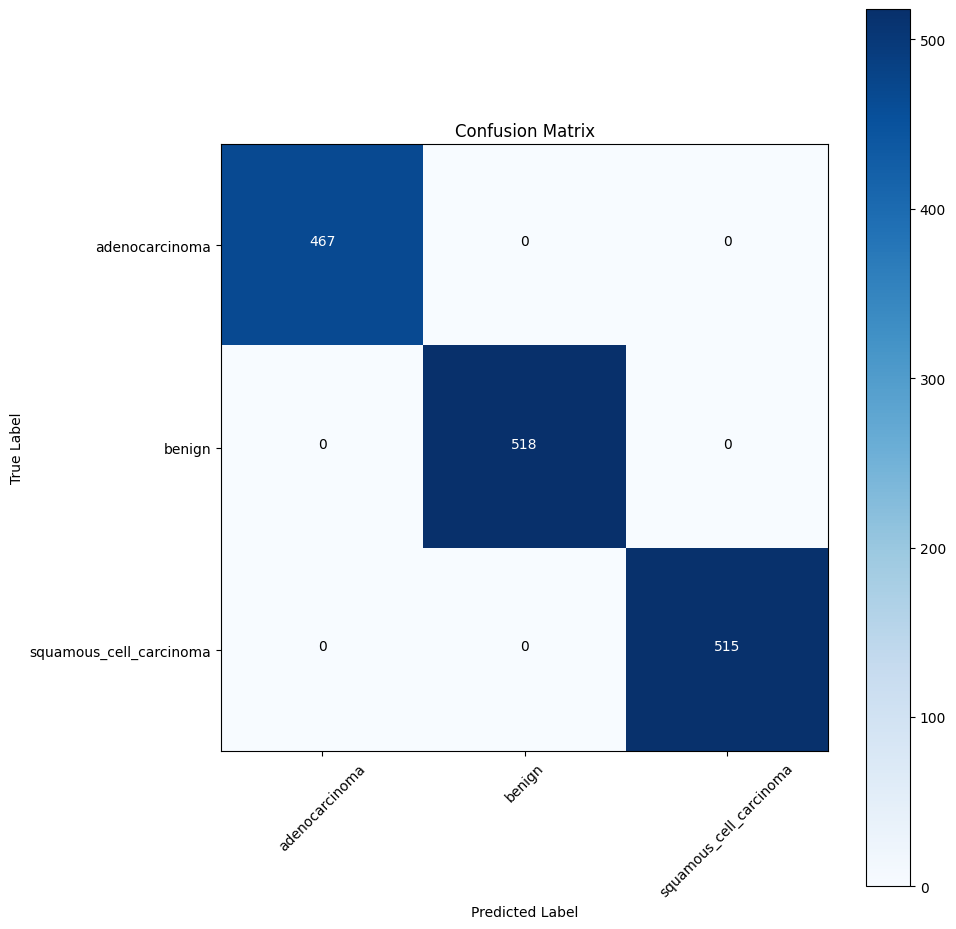

                         precision    recall  f1-score   support

         adenocarcinoma       1.00      1.00      1.00       467
                 benign       1.00      1.00      1.00       518
squamous_cell_carcinoma       1.00      1.00      1.00       515

               accuracy                           1.00      1500
              macro avg       1.00      1.00      1.00      1500
           weighted avg       1.00      1.00      1.00      1500

✅ Classification report saved to Lungcancer-ConvNeXt-classification_report.txt


In [45]:
img_name = f"{dataset_name}-{model_name}-confusion-matrix.png"
file_name = f"{dataset_name}-{model_name}-classification_report.txt"
class_names = test_loader.dataset.dataset.classes
y_pred, cm, report = evaluate_model(model, test_loader, class_names,img_name,file_name)

In [46]:
# Lưu lại model đã fine-tuned nếu cần
#torch.save(model.state_dict(), "vit_small_patch16_224_finetuned.pth")
